In [46]:
''' Import packages '''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
from toms_custom_functions import show_plots, log_predictor, fit_model
from toms_custom_functions import calculate_vif, create_interactions, elim_infl_outliers

In [47]:
''' Read in and examine data '''

# Set option to display all df columns
pd.set_option('display.max_columns', None)

# Suppress warnings
warnings.filterwarnings("ignore")

# Replace path with your own directory to re-run
my_path = "/Users/thomasfleming/Desktop/machine_learning"

# Read in mock dataset
df = pd.read_csv(f"{my_path}/home_data.csv")

# View head of dataset, non-null count, and dtypes
display(df.head())
display(df.info())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

None

In [48]:
''' Initial re-formatting and dropping of variables, based on logic '''

# Get year, month, and day from date field, then convert to datetime and then ordinal
df["date"] = pd.to_datetime(df["date"].str[:8]).map(dt.datetime.toordinal)

# Create basement indicator variable
df["basement"] = df["sqft_basement"].apply(lambda x: 1 if x > 0 else 0)

# Create yr_renovated indicator variable
df["renovated"] = df["yr_renovated"].apply(lambda x: 1 if x > 0 else 0)

# Create dummy variables for zipcodes and drop zipcode, lat, and long fields
zip_dummies = pd.get_dummies(df["zipcode"], prefix="zip")
zip_list = zip_dummies.columns.tolist()
for col in zip_list:
    df[col] = zip_dummies[col]

# Drop unneeded variables
df.drop(columns=["zipcode", "lat", "long"], inplace=True)

# View head of dataset, non-null count, and dtypes
display(df.head())
display(df.info())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,basement,renovated,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,zip_98032,zip_98033,zip_98034,zip_98038,zip_98039,zip_98040,zip_98042,zip_98045,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98065,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,7129300520,735519,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,1340,5650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,6414100192,735576,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5631500400,735654,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,2720,8062,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2487200875,735576,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,1360,5000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1954400510,735647,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,1800,7503,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 90 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  int64  
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  sqft_living15  21613 non-null  int64  
 17  sqft_lot15     21613 non-null  int64  
 18  baseme

None

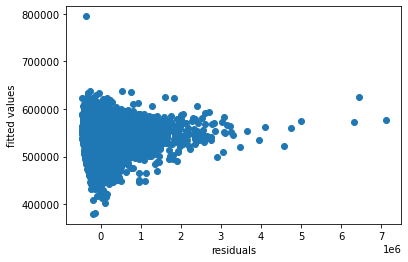

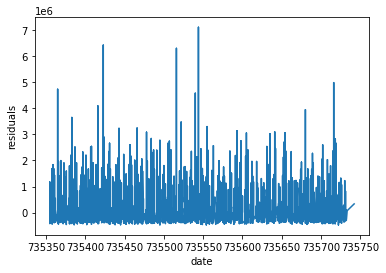

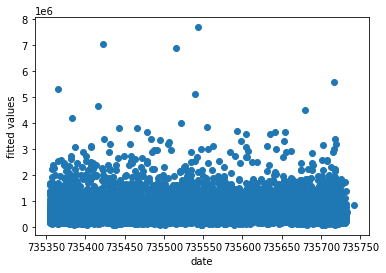

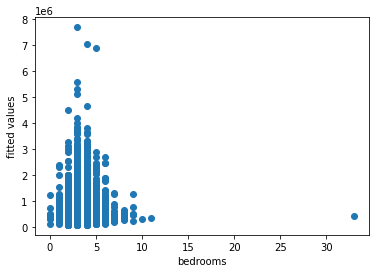

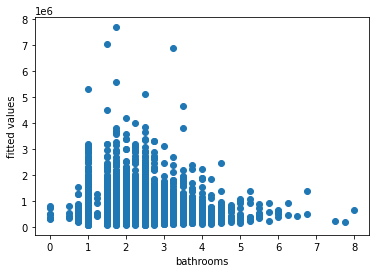

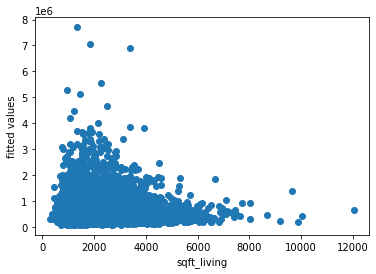

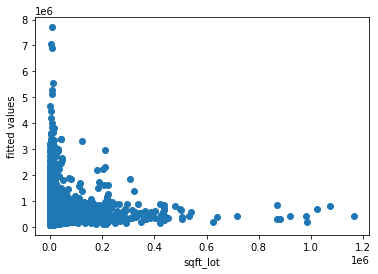

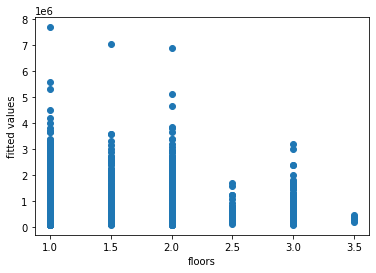

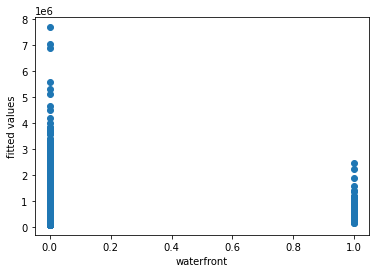

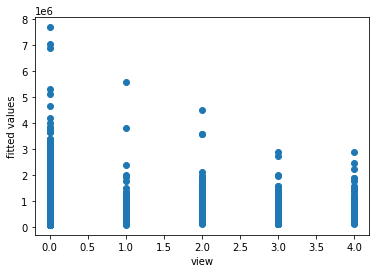

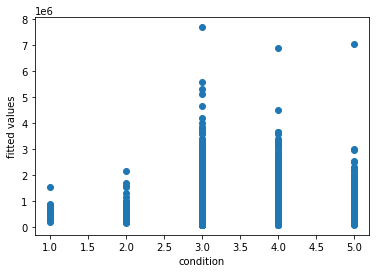

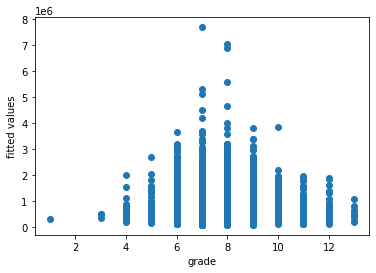

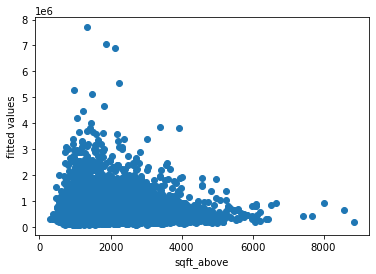

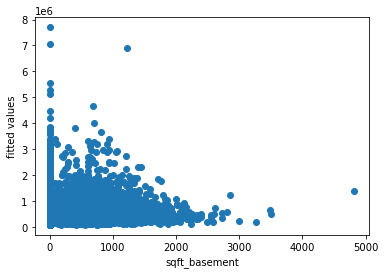

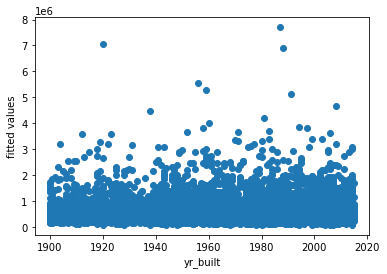

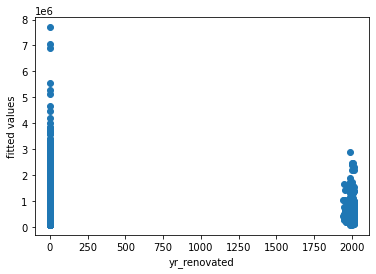

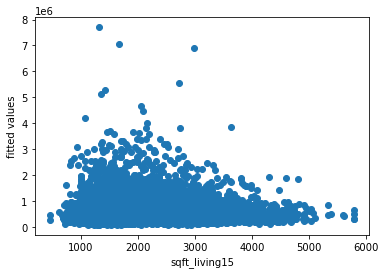

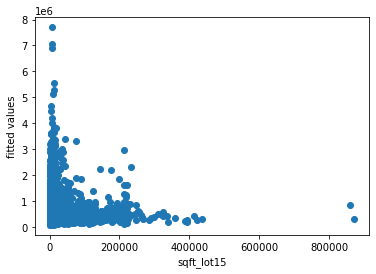

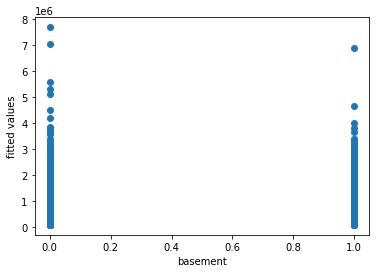

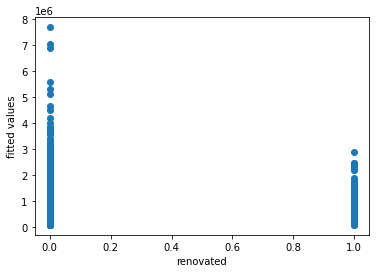

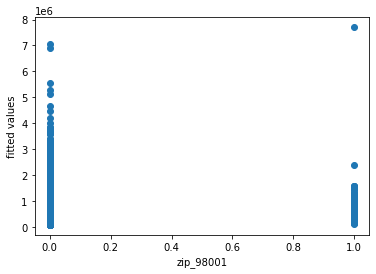

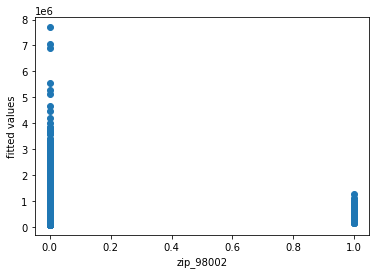

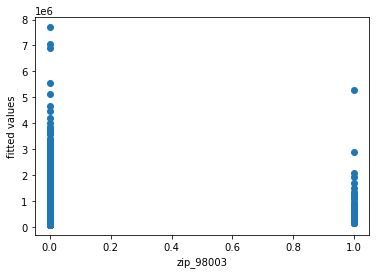

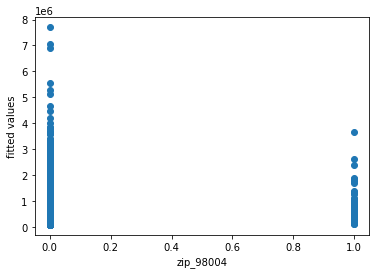

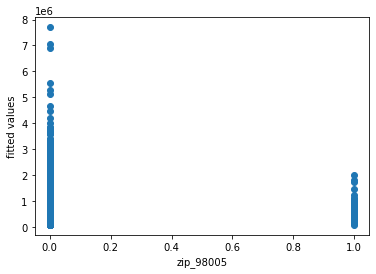

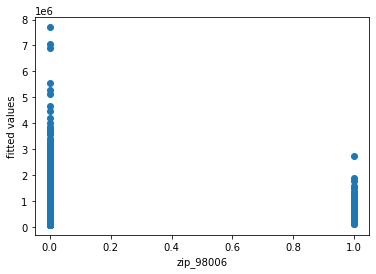

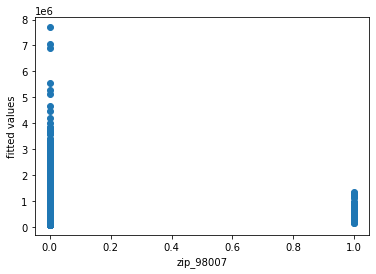

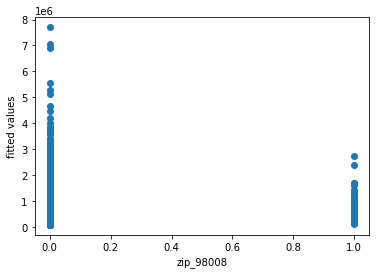

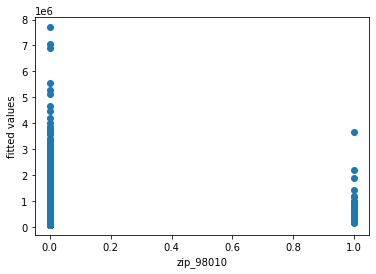

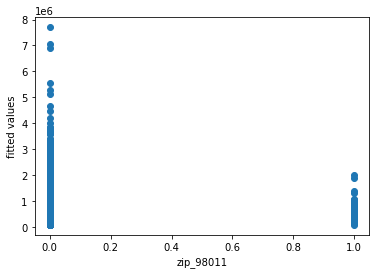

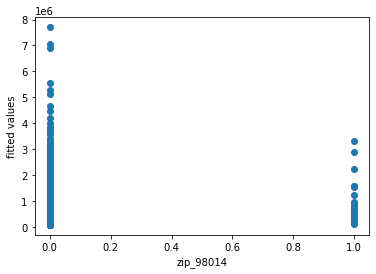

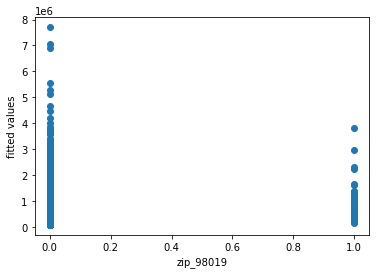

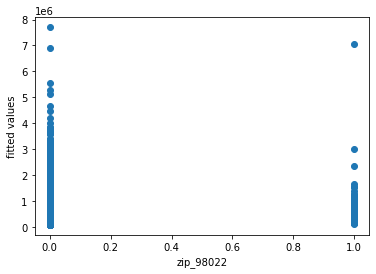

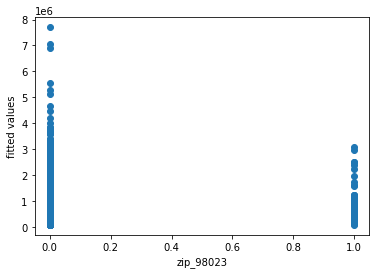

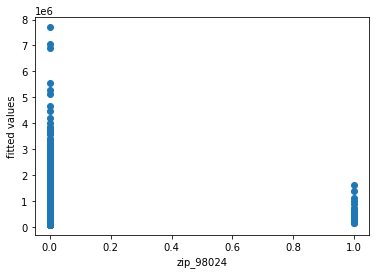

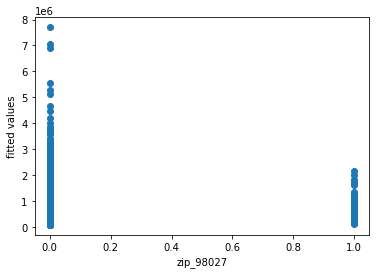

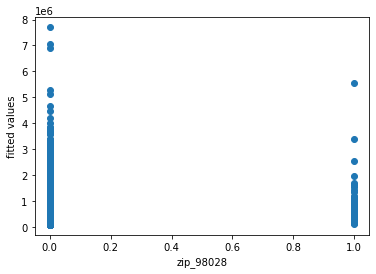

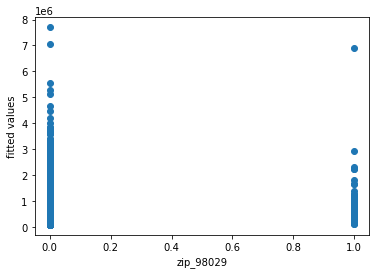

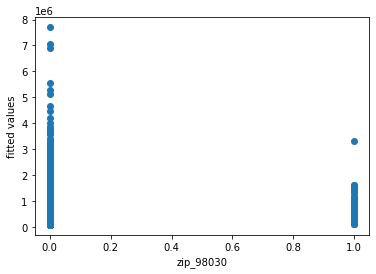

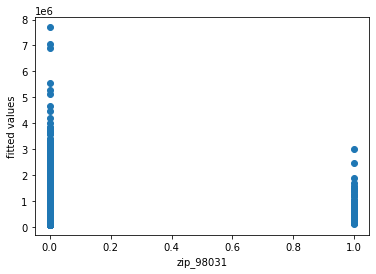

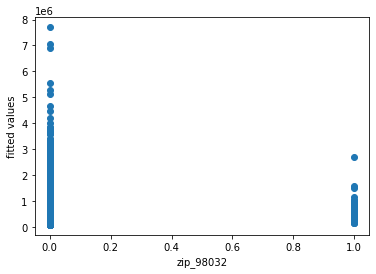

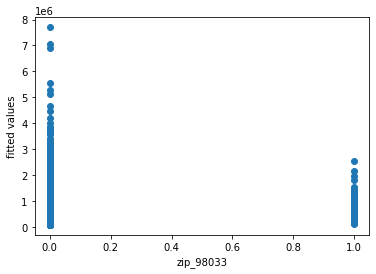

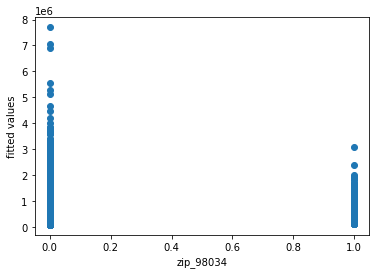

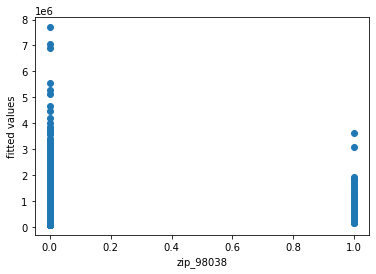

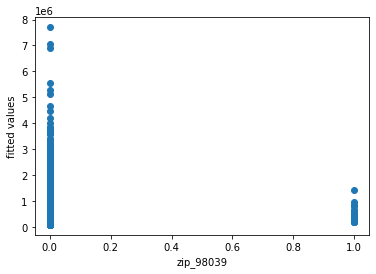

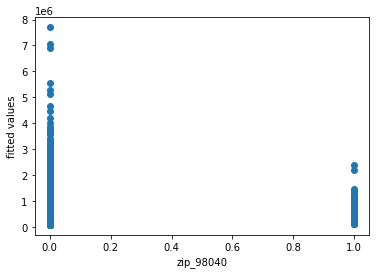

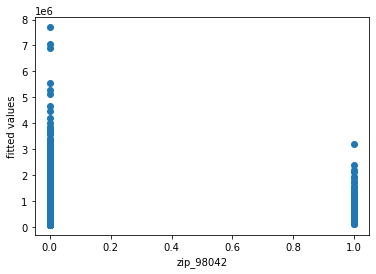

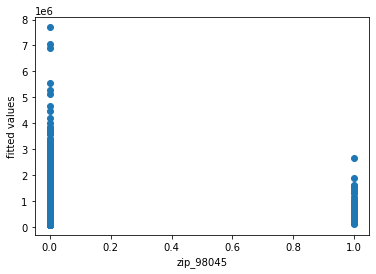

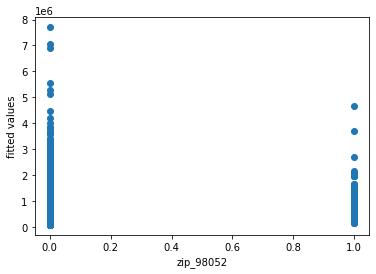

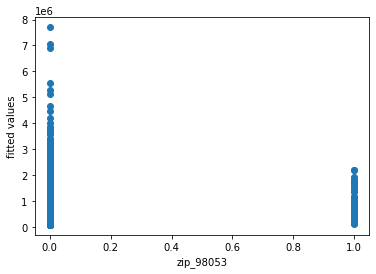

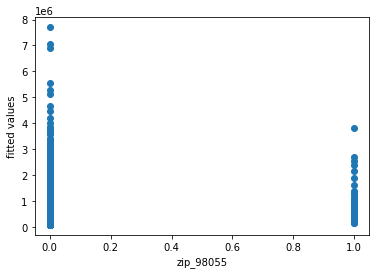

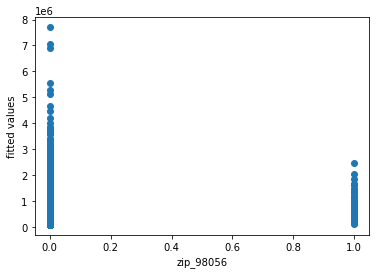

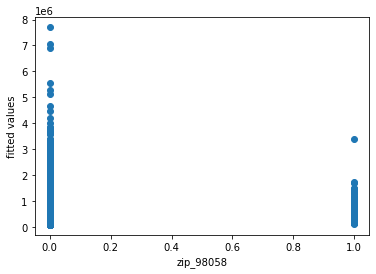

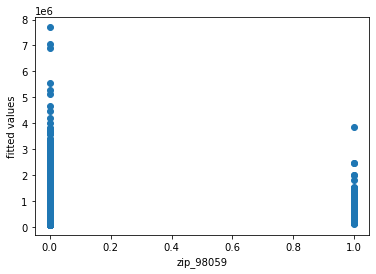

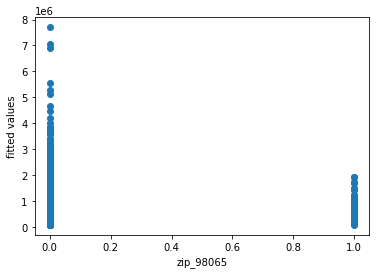

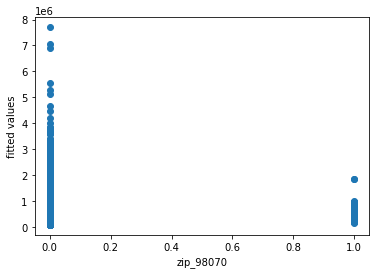

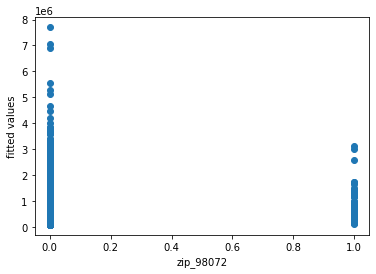

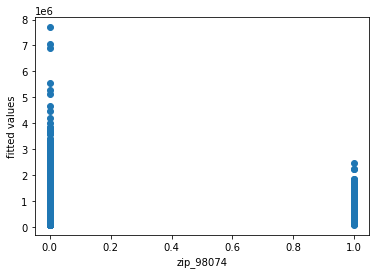

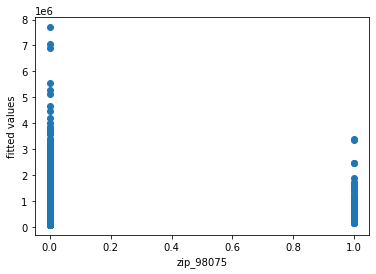

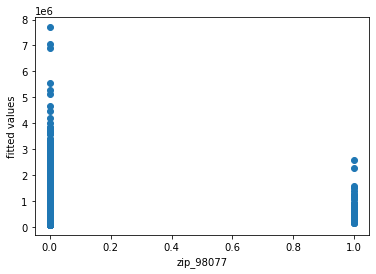

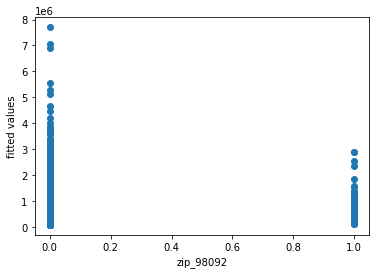

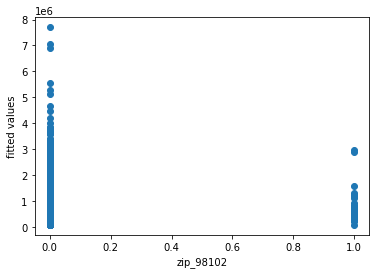

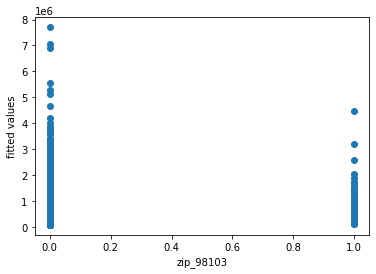

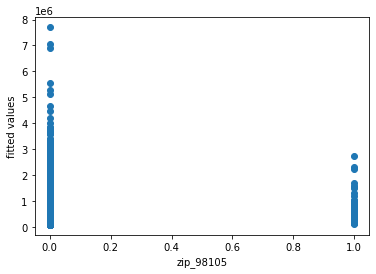

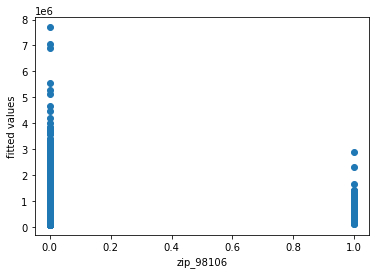

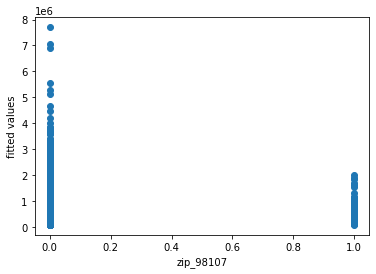

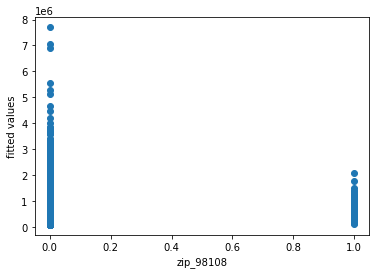

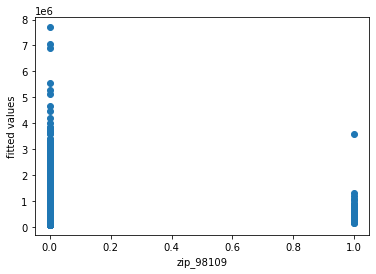

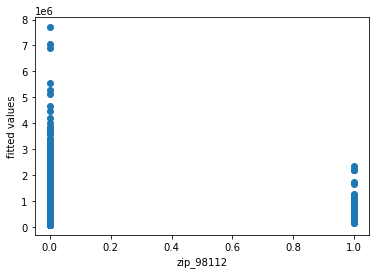

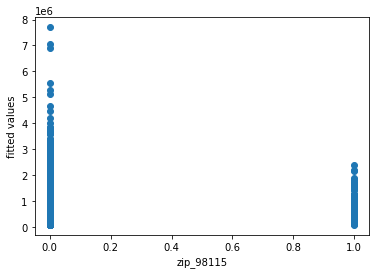

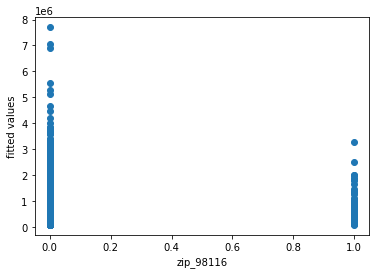

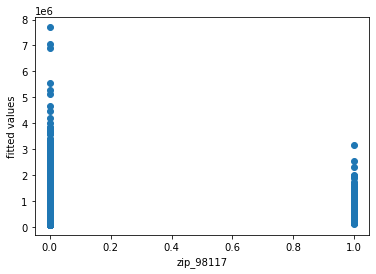

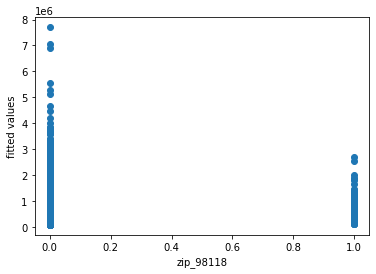

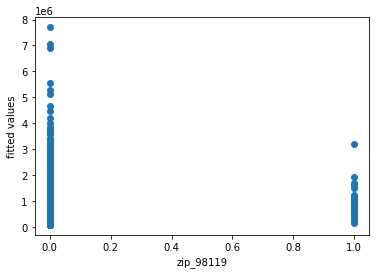

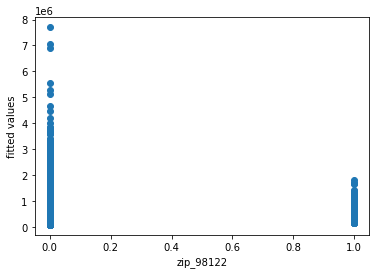

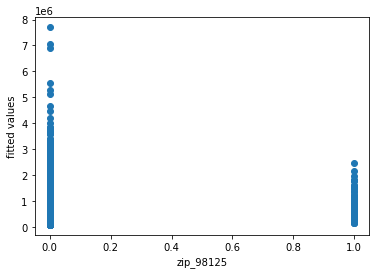

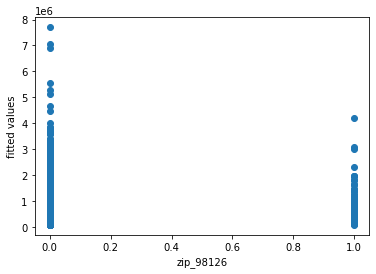

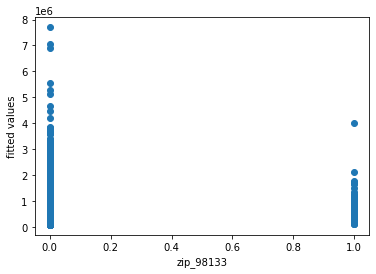

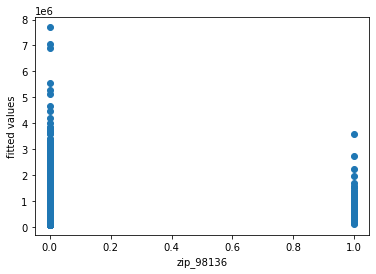

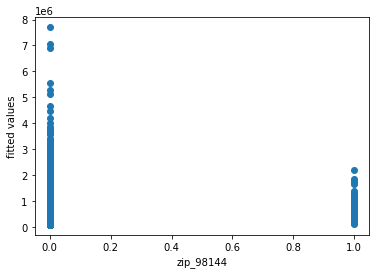

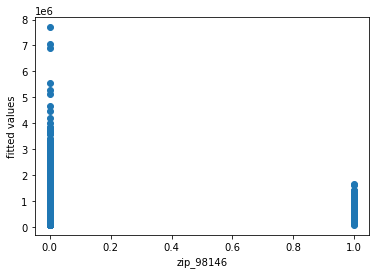

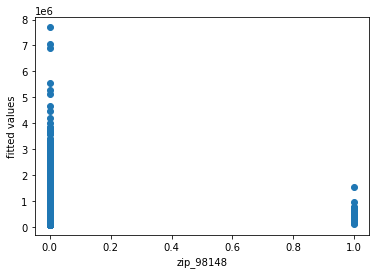

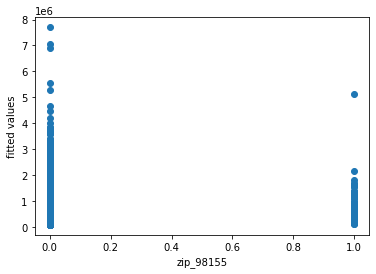

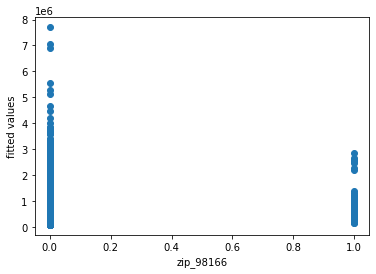

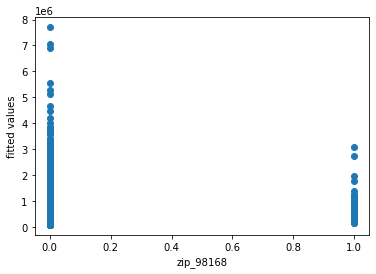

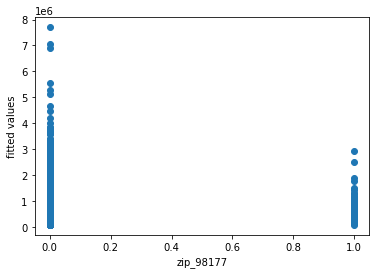

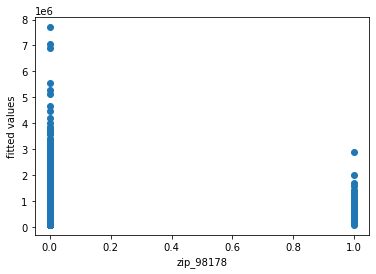

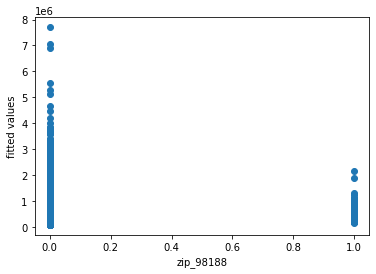

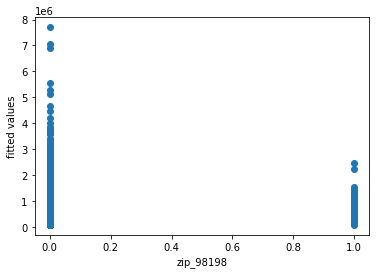

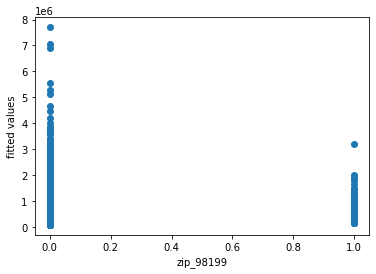

In [49]:
''' Take an initial look at the residual and predictor relationships with the fitted values '''

# Set y to price
y = df["price"]

# Set design matrix to include all fields except select ones
X = df.loc[:, ~df.columns.isin(["id", "price"])]

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

# Fit initial model and see relationships
show_plots(X_train, y_train)

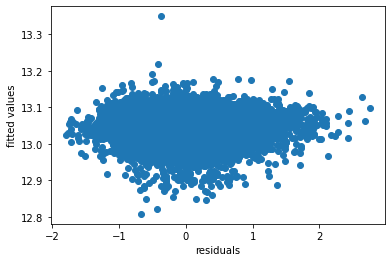

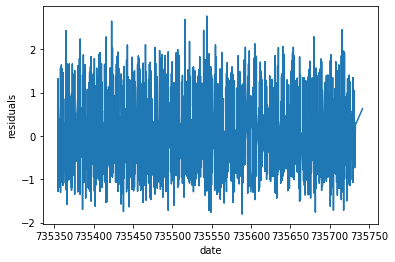

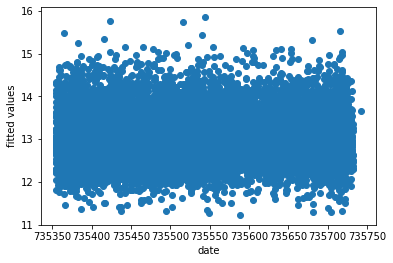

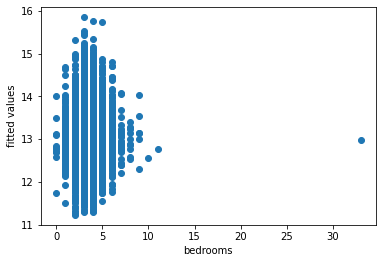

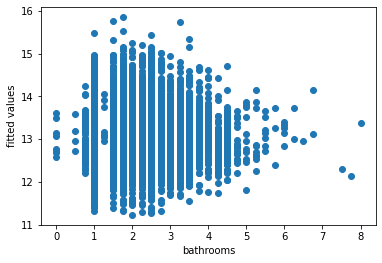

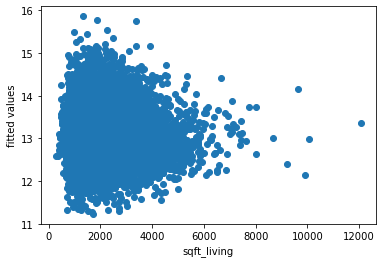

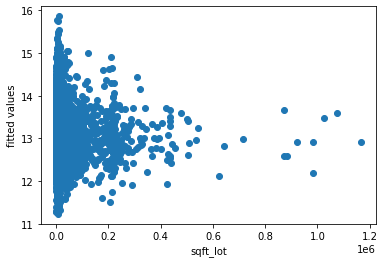

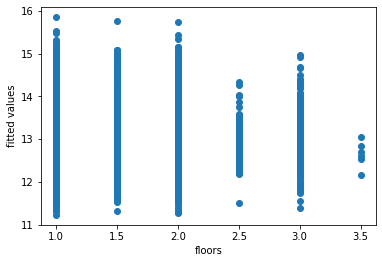

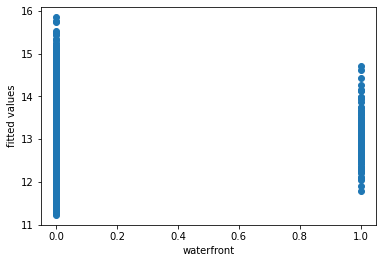

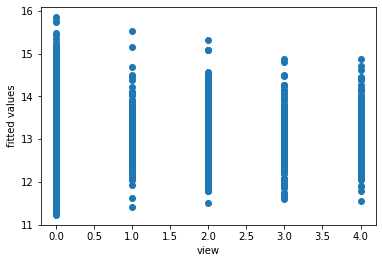

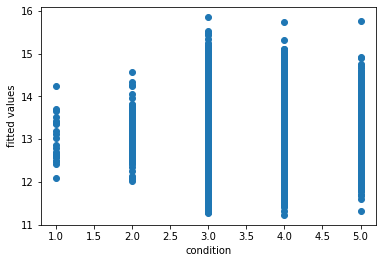

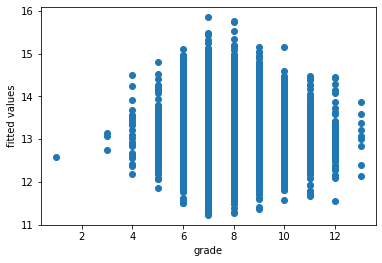

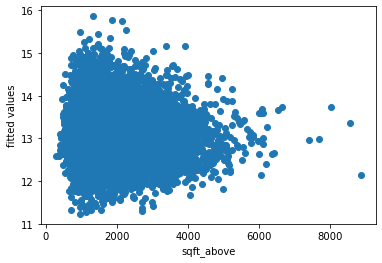

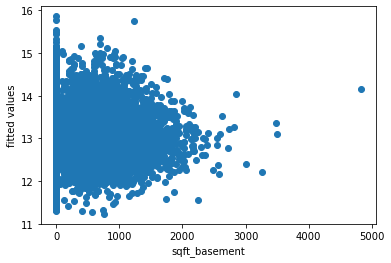

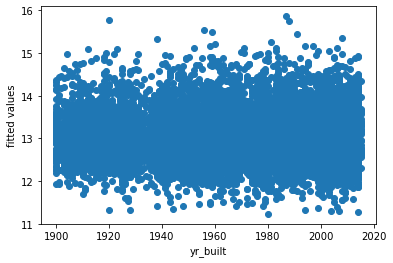

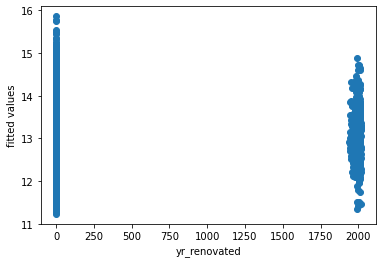

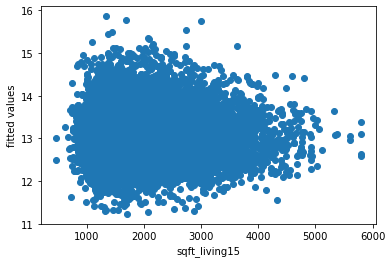

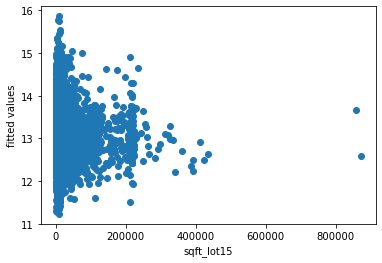

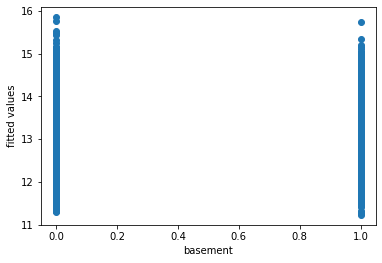

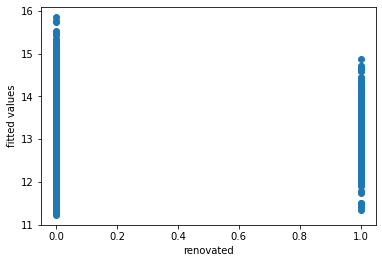

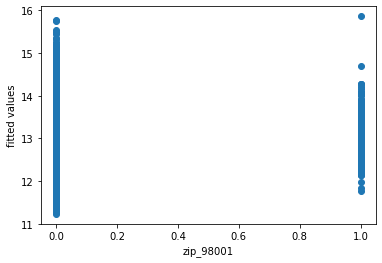

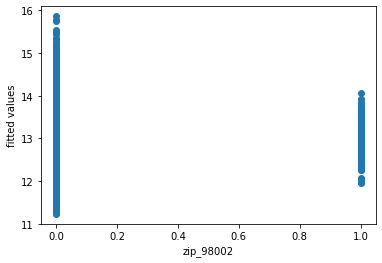

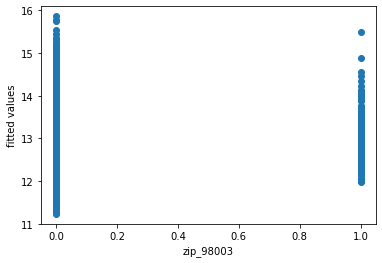

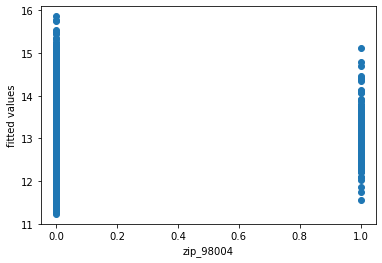

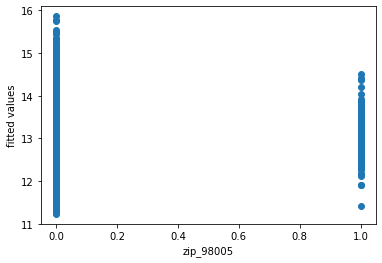

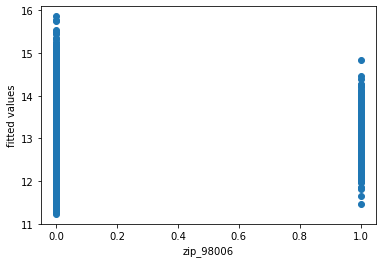

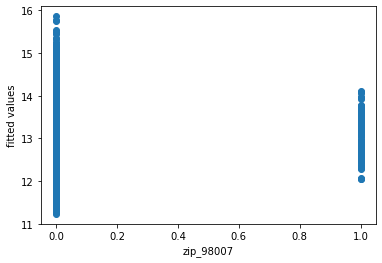

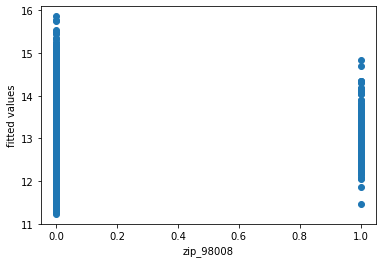

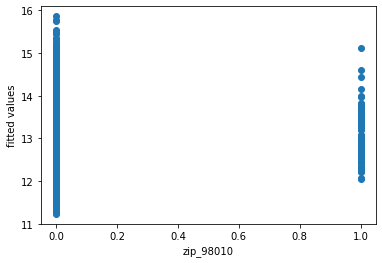

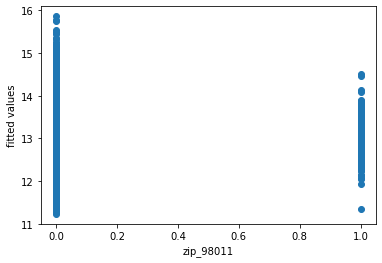

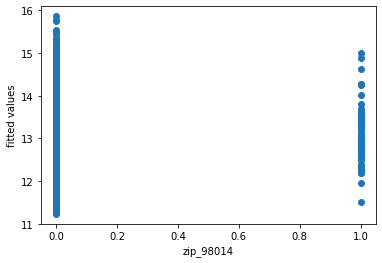

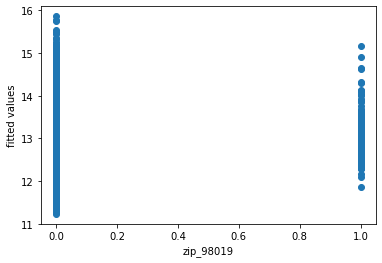

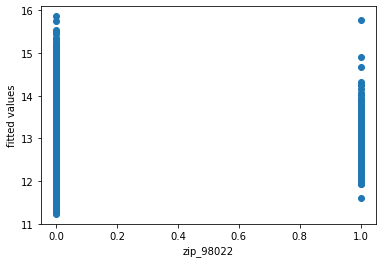

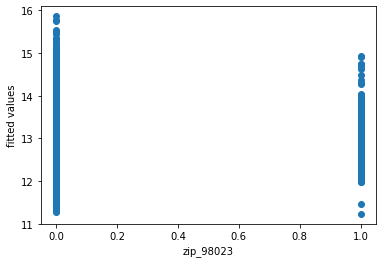

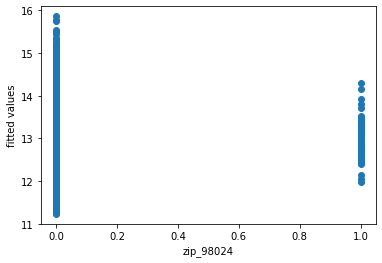

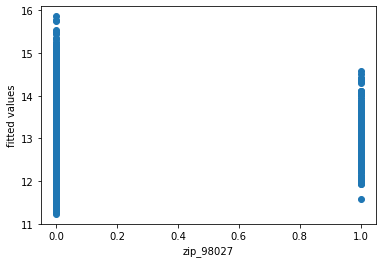

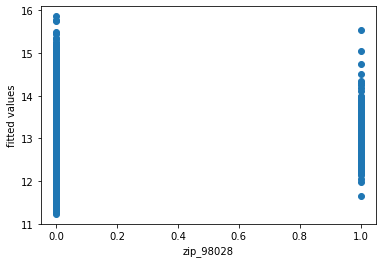

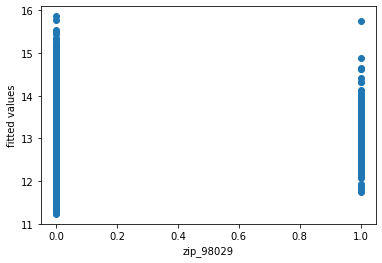

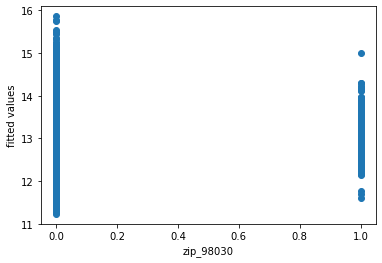

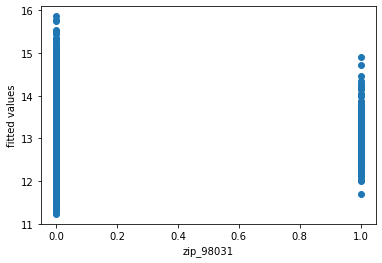

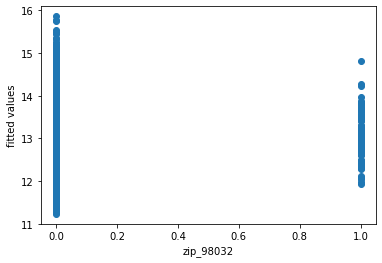

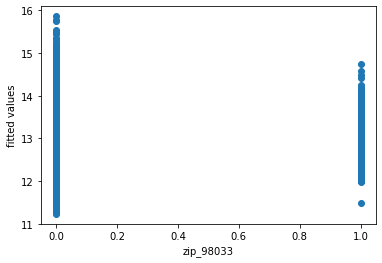

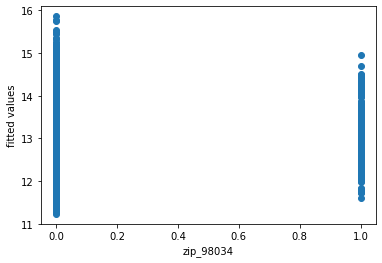

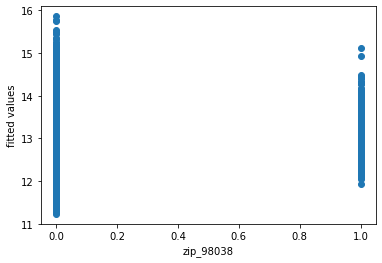

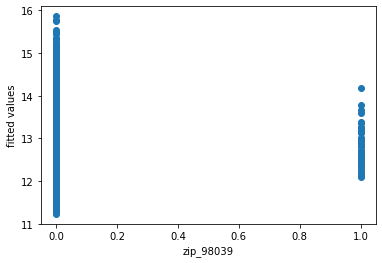

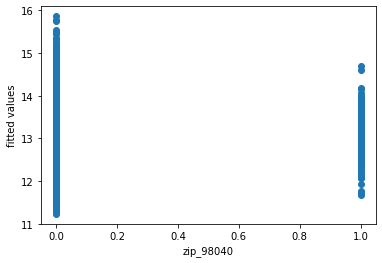

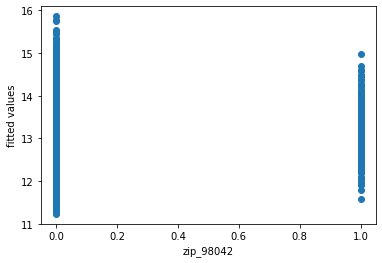

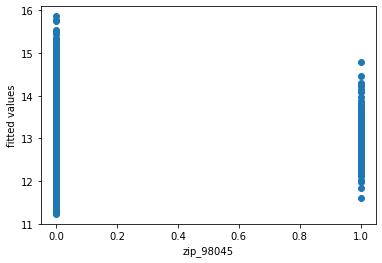

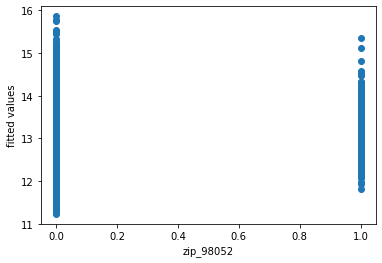

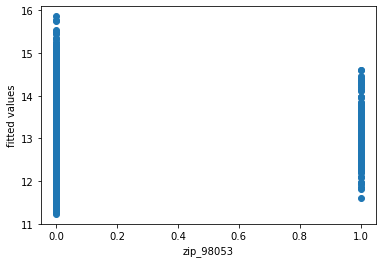

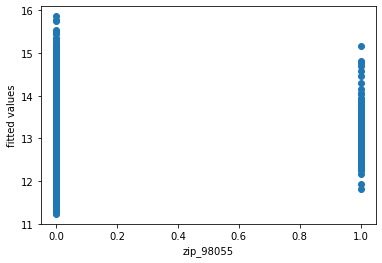

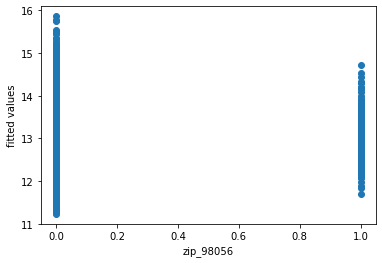

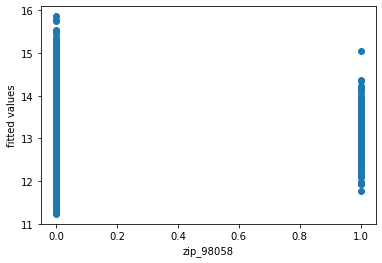

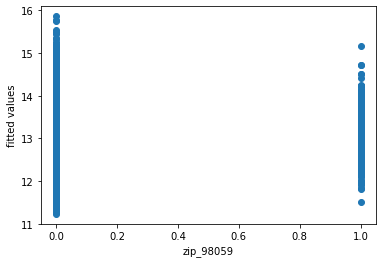

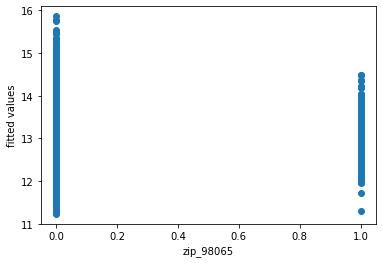

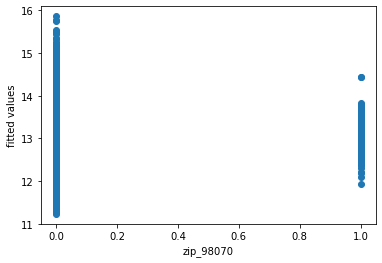

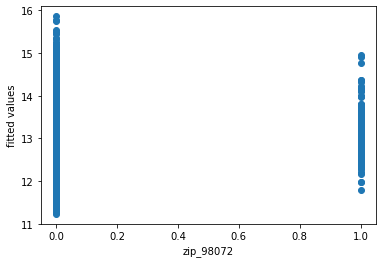

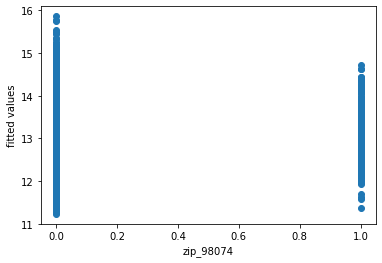

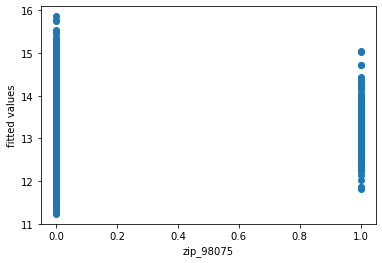

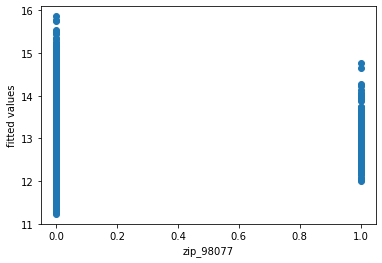

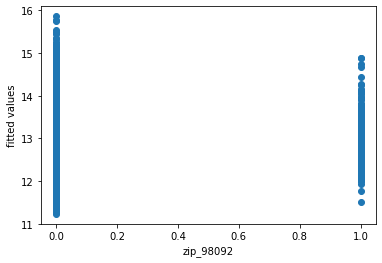

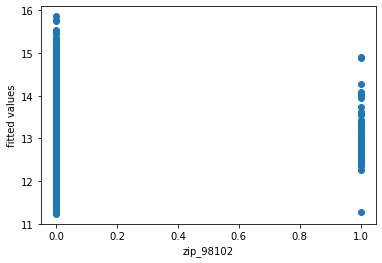

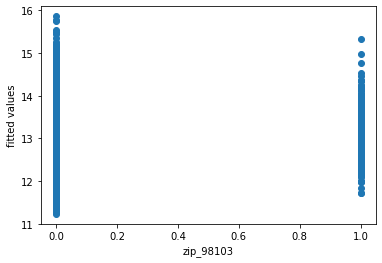

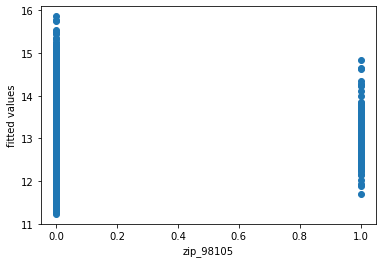

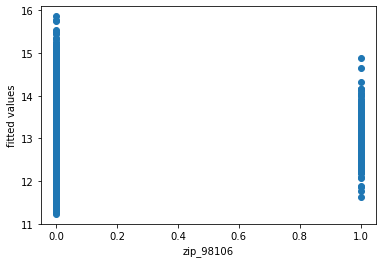

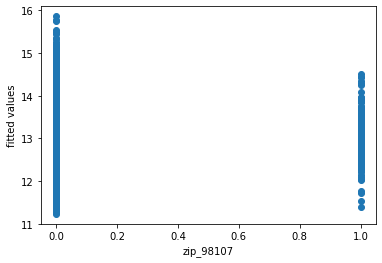

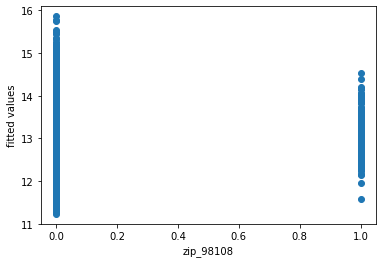

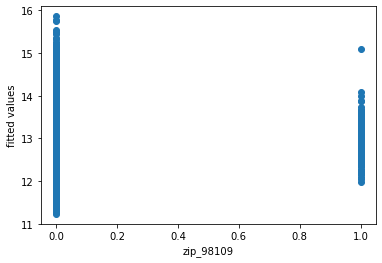

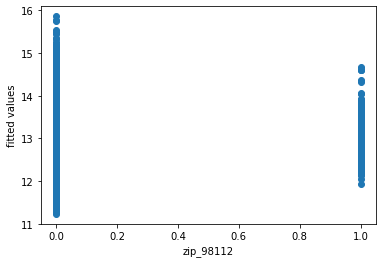

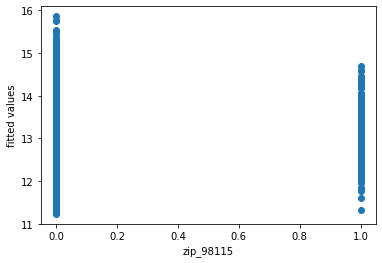

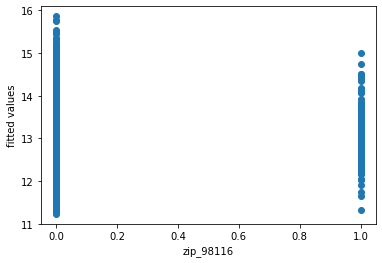

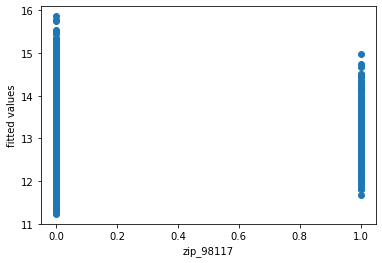

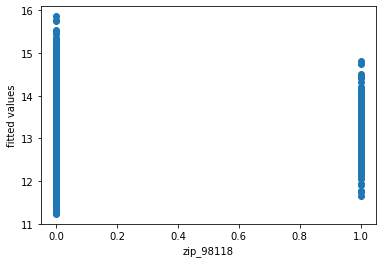

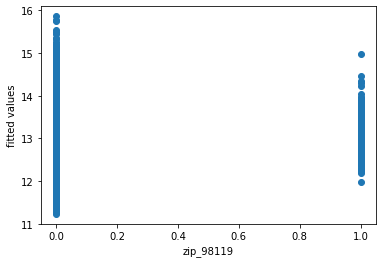

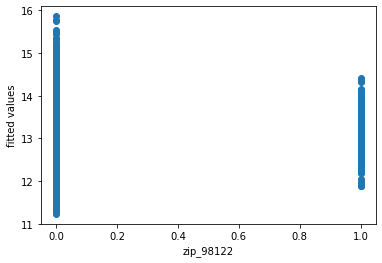

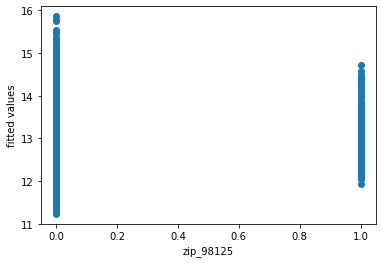

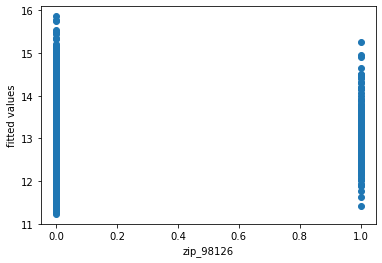

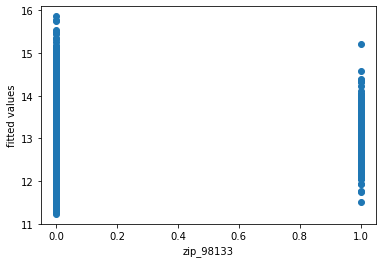

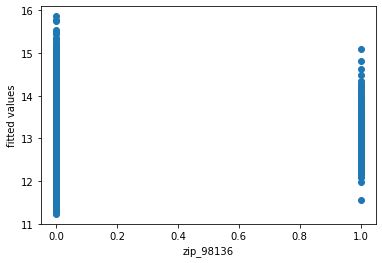

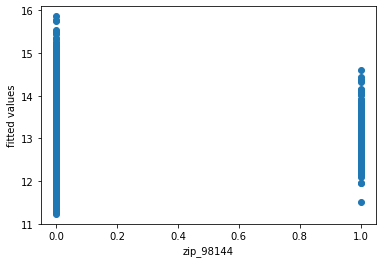

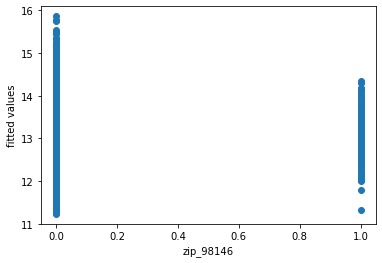

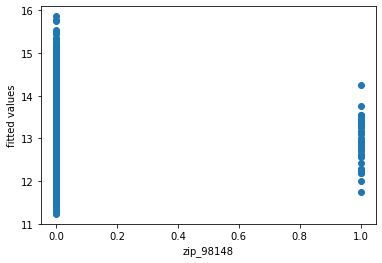

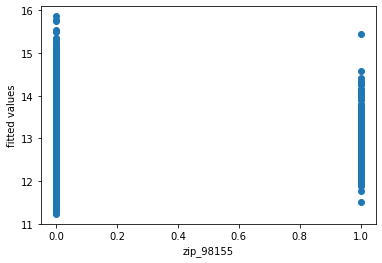

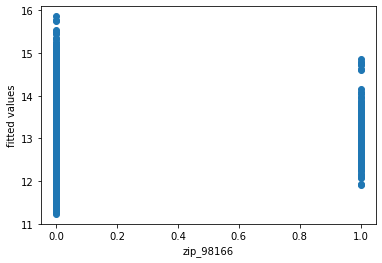

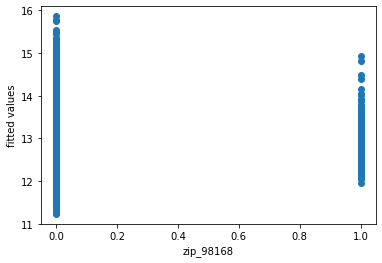

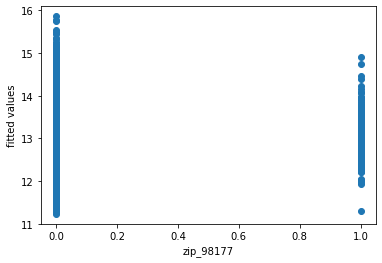

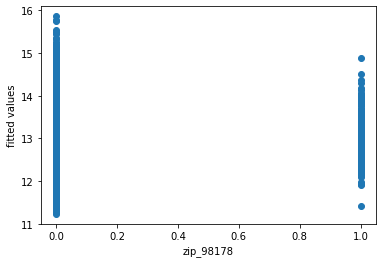

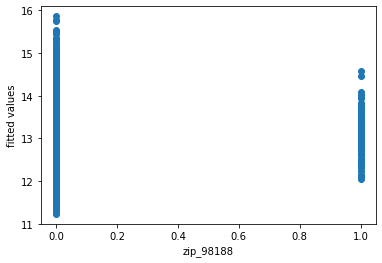

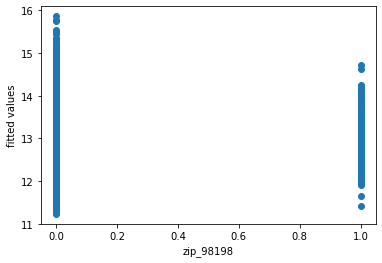

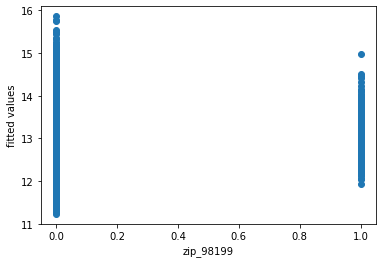

In [50]:
''' Log the response to control the heteroskedasticity '''

# Log price
y_train = np.log(df.iloc[y_train.index.tolist()]["price"])
y_test = np.log(df.iloc[y_test.index.tolist()]["price"])

# Fit model again with logged response
show_plots(X_train, y_train)

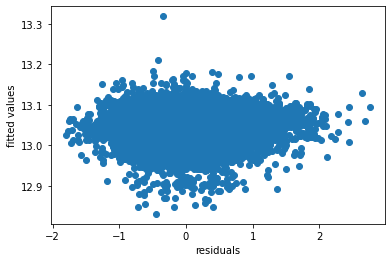

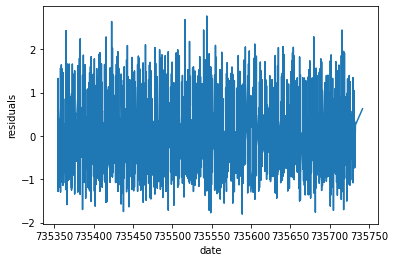

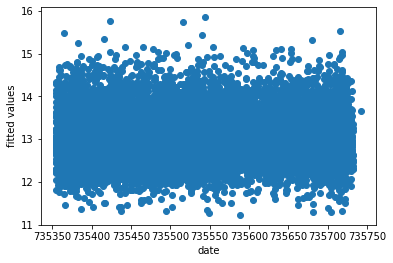

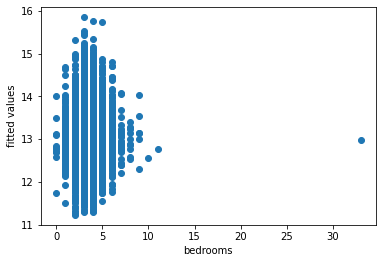

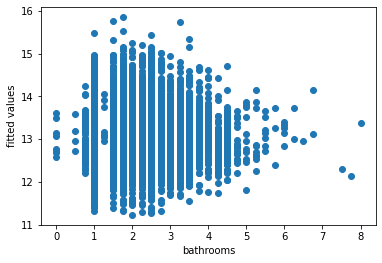

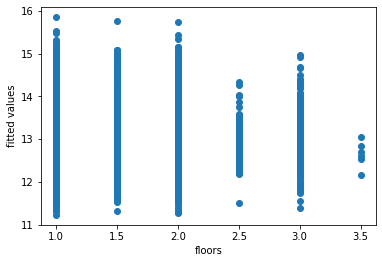

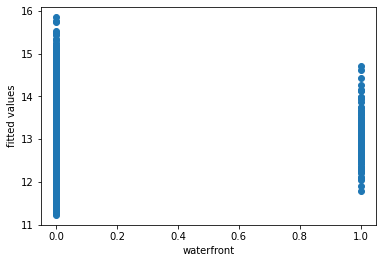

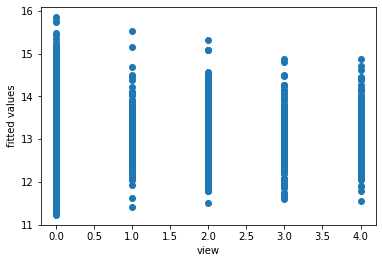

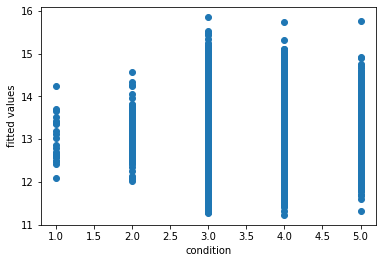

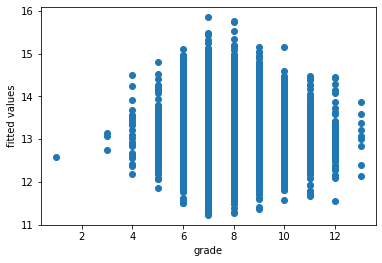

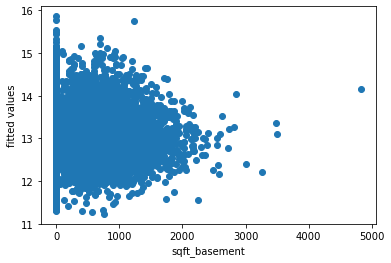

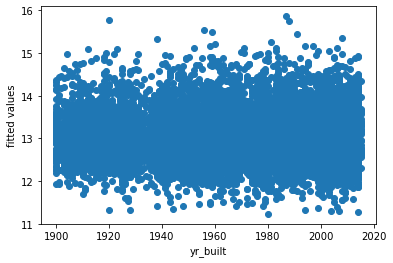

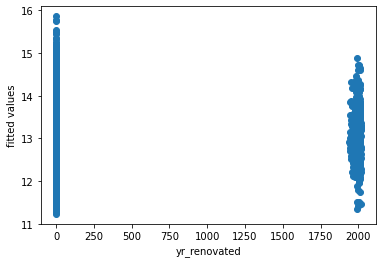

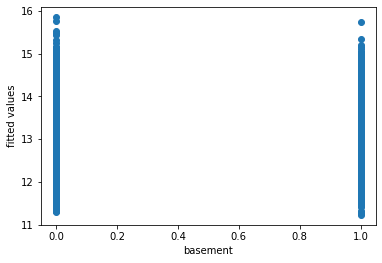

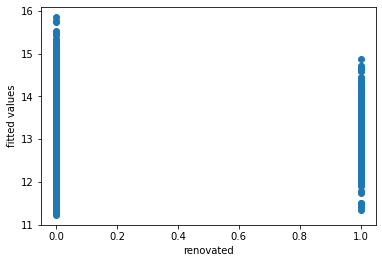

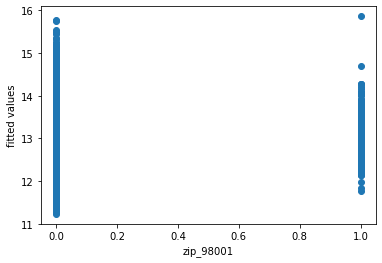

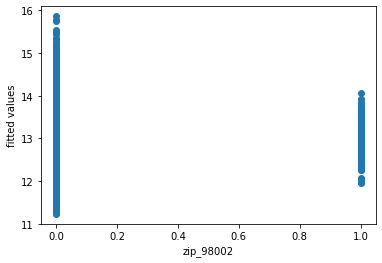

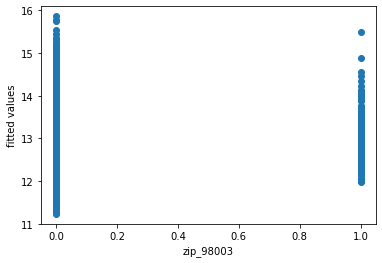

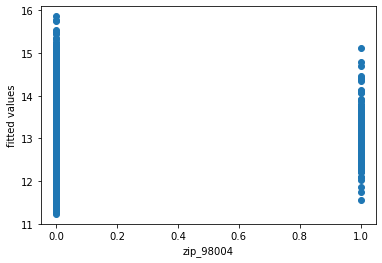

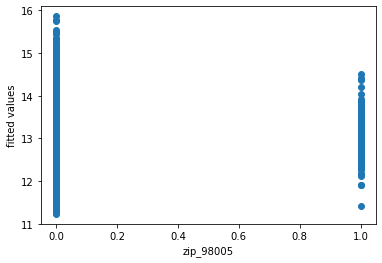

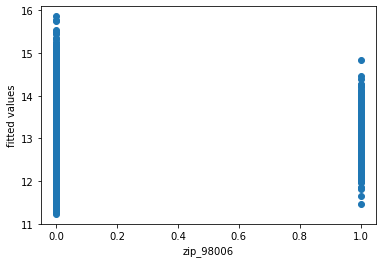

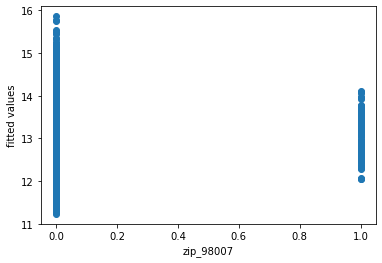

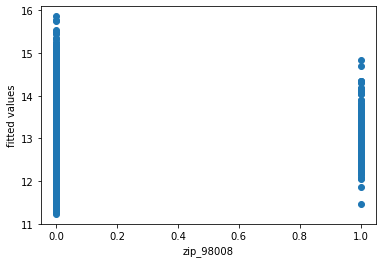

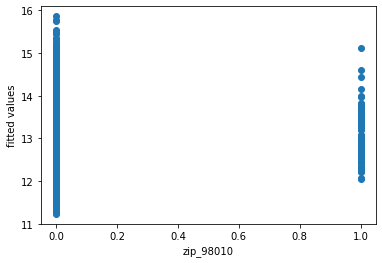

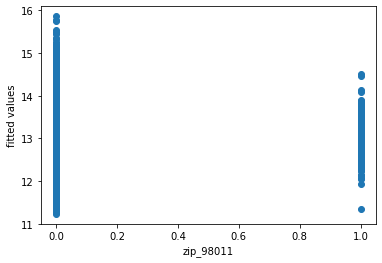

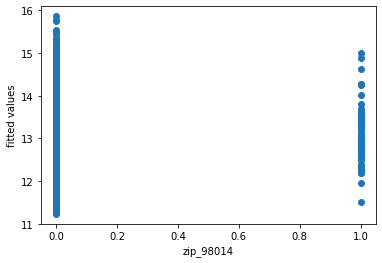

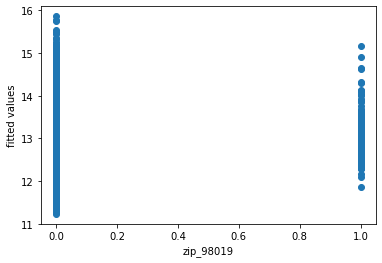

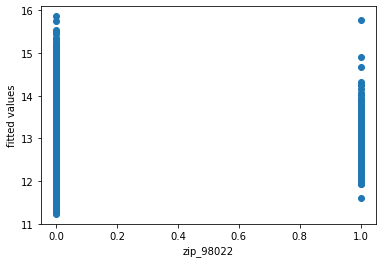

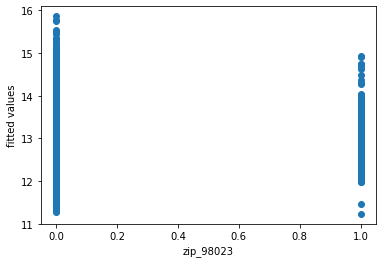

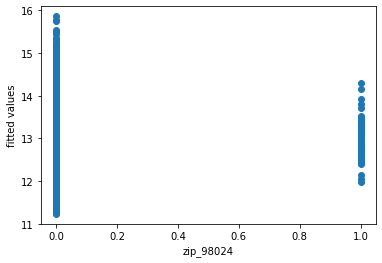

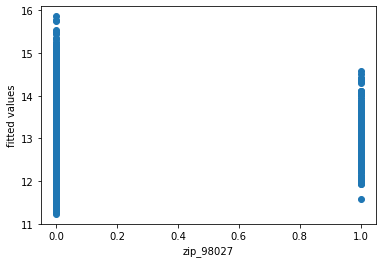

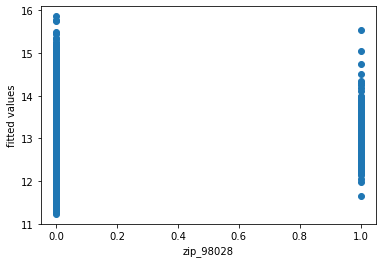

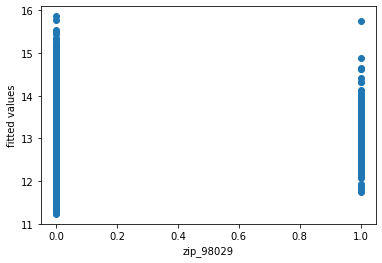

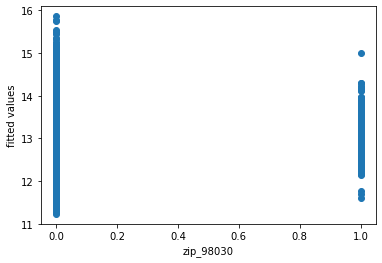

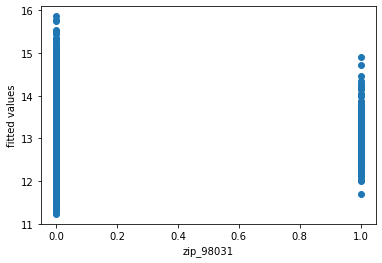

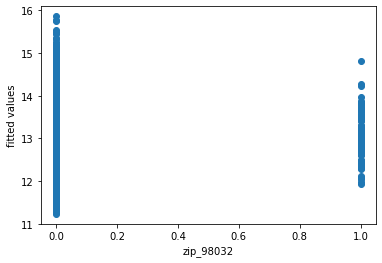

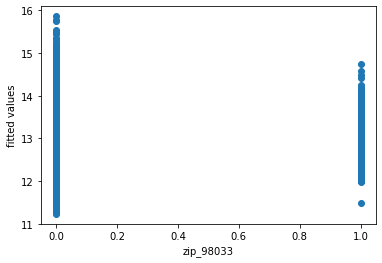

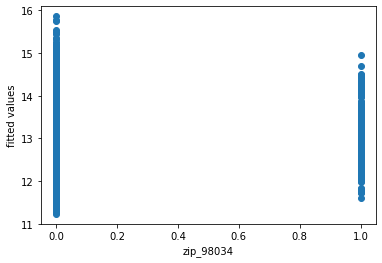

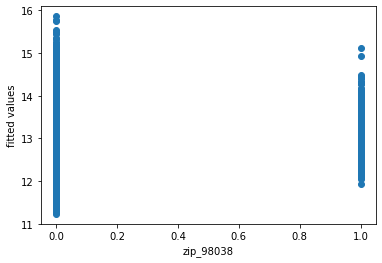

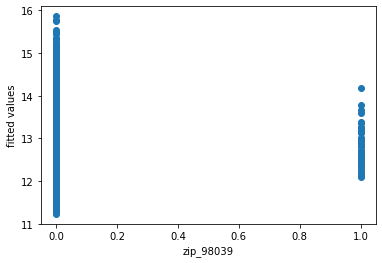

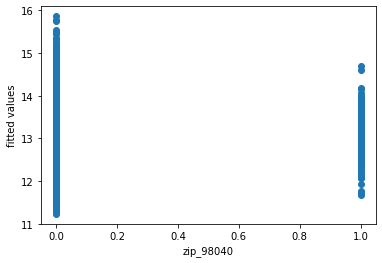

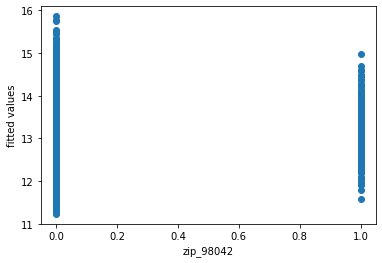

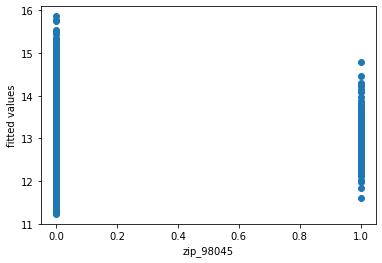

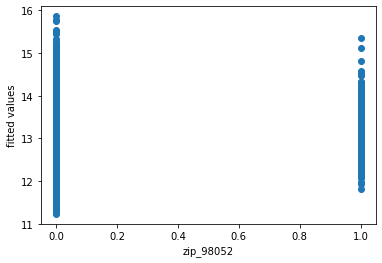

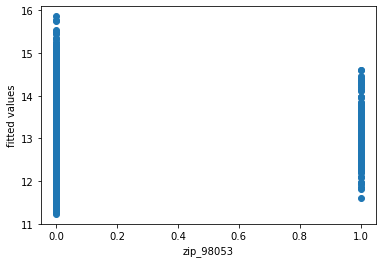

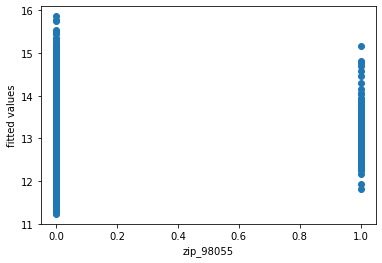

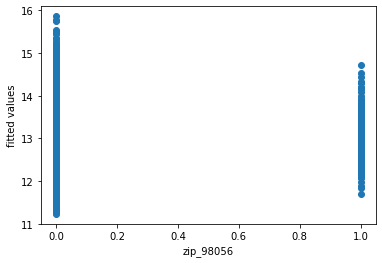

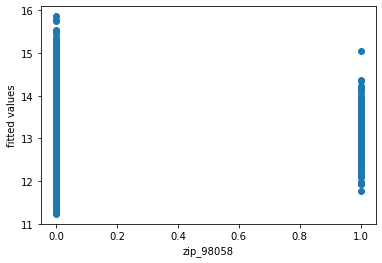

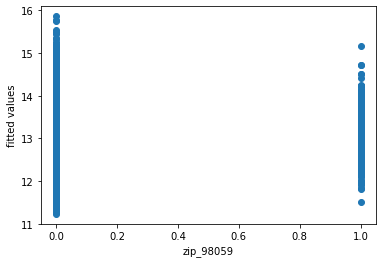

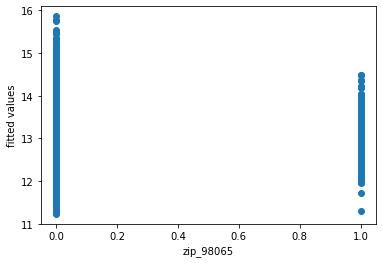

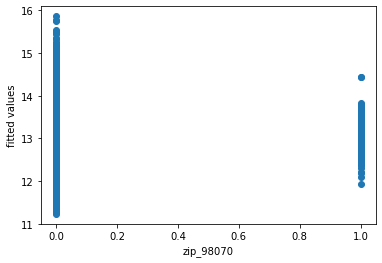

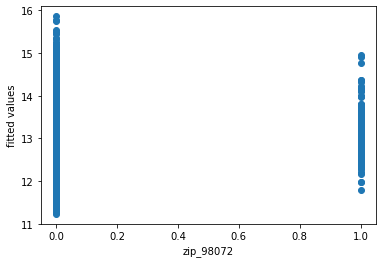

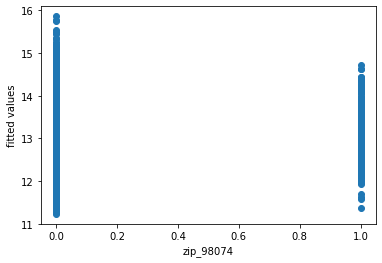

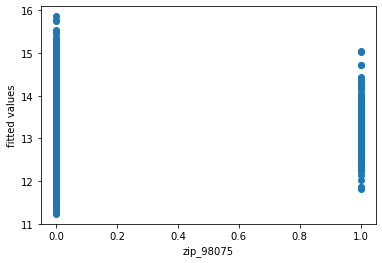

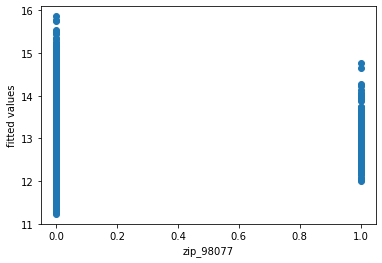

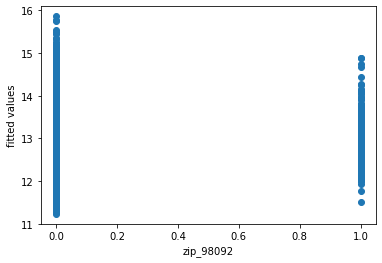

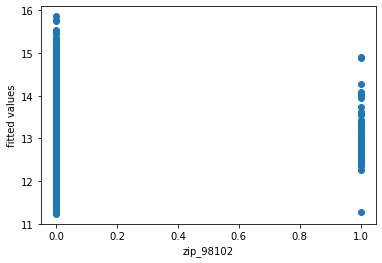

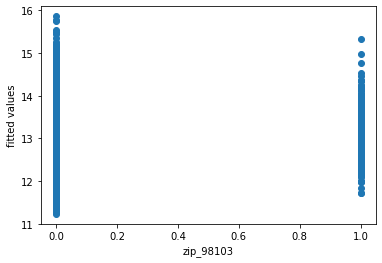

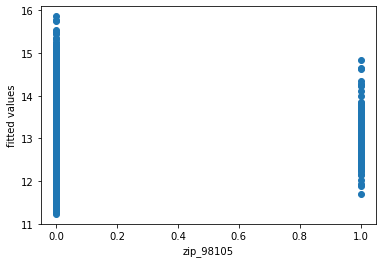

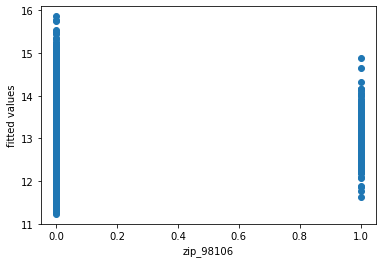

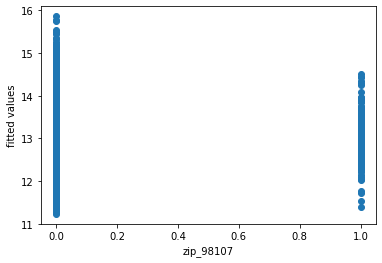

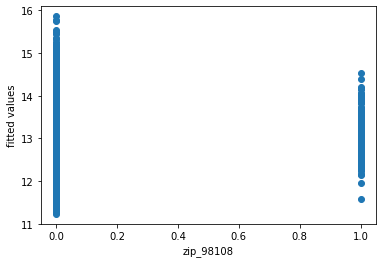

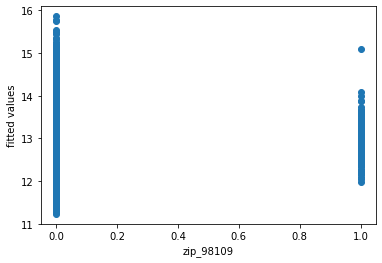

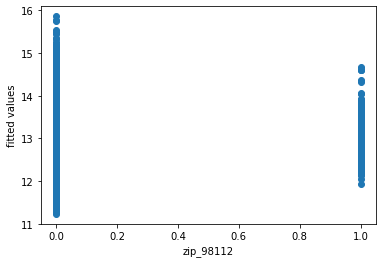

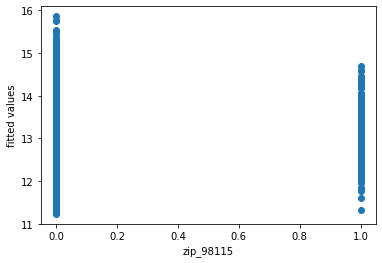

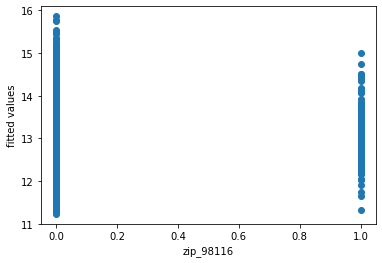

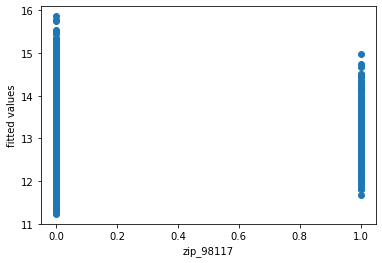

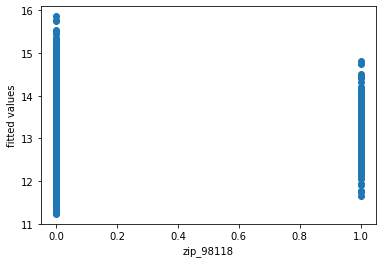

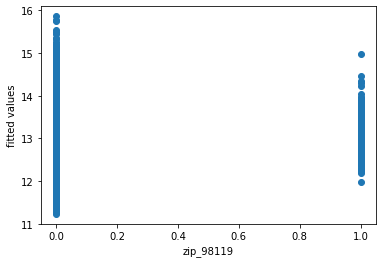

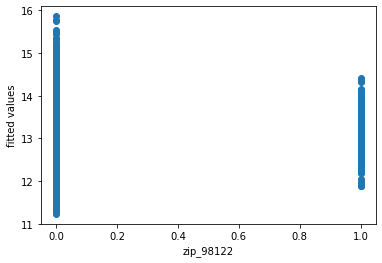

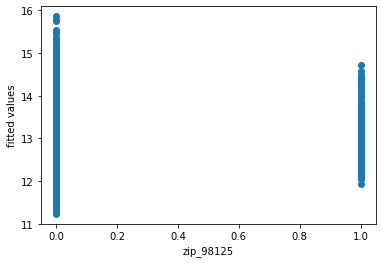

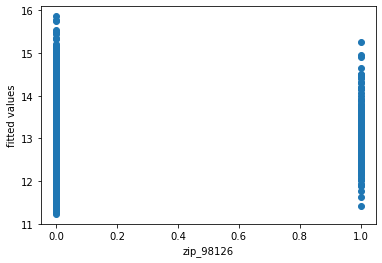

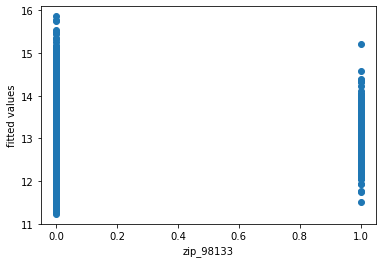

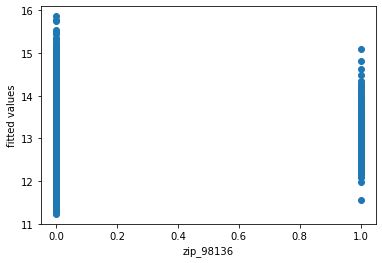

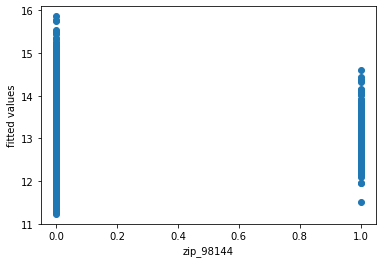

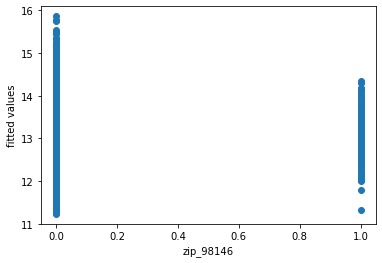

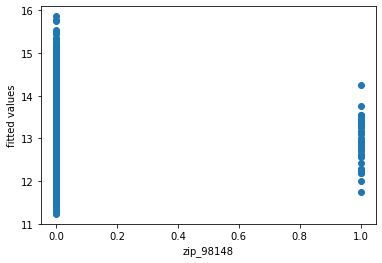

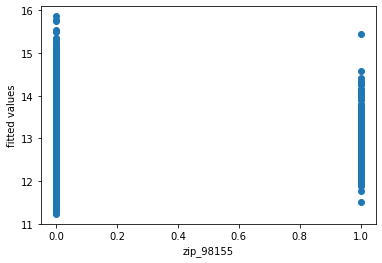

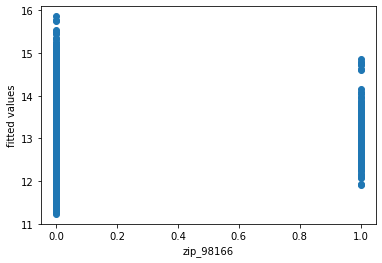

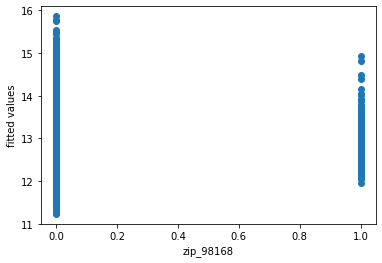

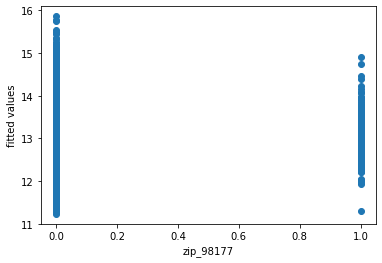

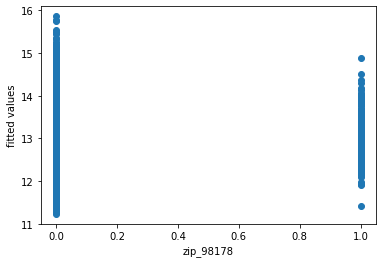

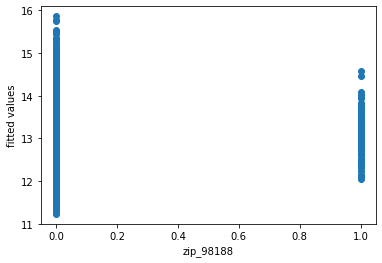

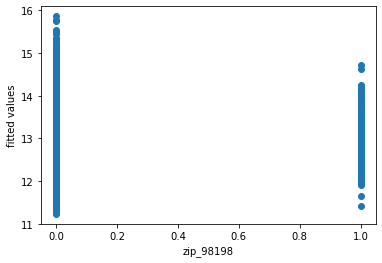

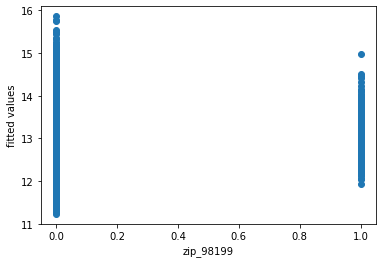

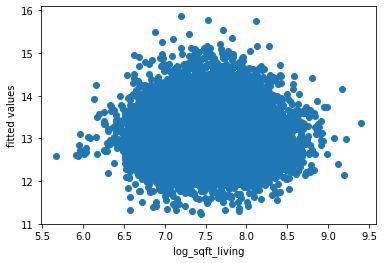

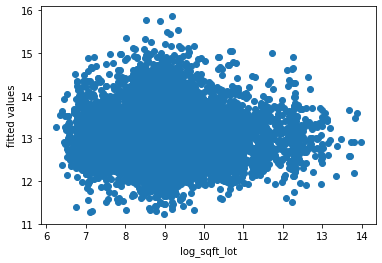

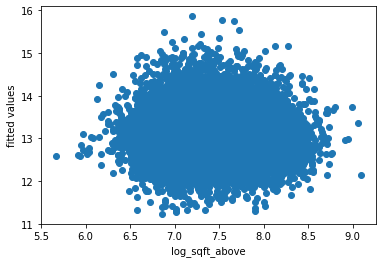

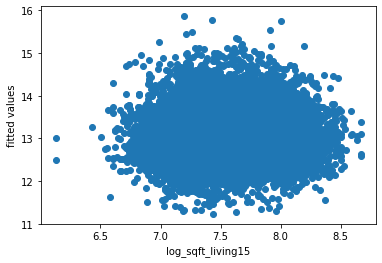

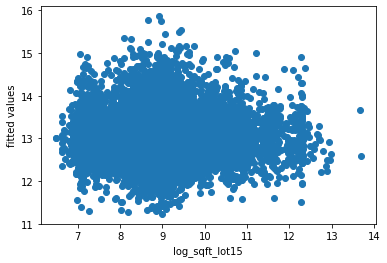

In [51]:
''' Transform non-linear X variables, or ones with non-constant variance '''
    
cols_to_log = ["sqft_living", "sqft_lot", "sqft_above", "sqft_living15",
               "sqft_lot15"]

for col in cols_to_log:
    log_predictor(X_train, col)
    log_predictor(X_test, col)

show_plots(X_train, y_train)

In [52]:
''' Assess model after correcting for non-constant variance and non-linearity '''

fit_model(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     1524.
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:45:04   Log-Likelihood:                 5336.3
No. Observations:               17290   AIC:                        -1.050e+04
Df Residuals:                   17202   BIC:                            -9814.
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -147.6806      8.75

In [53]:
''' Remove insignificant variables and assess model '''

X_train.drop(columns=["sqft_basement"], inplace=True)
X_test.drop(columns=["sqft_basement"], inplace=True)

fit_model(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     1541.
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:45:07   Log-Likelihood:                 5335.8
No. Observations:               17290   AIC:                        -1.050e+04
Df Residuals:                   17203   BIC:                            -9823.
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -147.6142      8.75

In [54]:
''' Look for variables with high collinearity '''
    
calculate_vif(X_train, 5)

,variables,VIF
54,zip_98103,1.216180e+06
35,zip_98038,1.188979e+06
61,zip_98115,1.181446e+06
40,zip_98052,1.126853e+06
38,zip_98042,1.109567e+06
...,...,...
11,renovated,1.622987e+04
82,log_sqft_living,1.988745e+01
84,log_sqft_above,1.981731e+01
83,log_sqft_lot,7.111168e+00


In [55]:
''' Check correlations for variables with high collinearity '''
X_p = X_train.loc[:, X_train.columns.isin(["yr_renovated", "renovated", "log_sqft_living", "log_sqft_lot",
                             "log_sqft_above", "log_sqft_lot15"])]

P = X_p.corr()

display(P)

,yr_renovated,renovated,log_sqft_living,log_sqft_lot,log_sqft_above,log_sqft_lot15
yr_renovated,1.000000,0.999968,0.045693,0.026639,0.020140,0.024587
renovated,0.999968,1.000000,0.045367,0.026813,0.019977,0.024722
log_sqft_living,0.045693,0.045367,1.000000,0.321361,0.864310,0.299145
log_sqft_lot,0.026639,0.026813,0.321361,1.000000,0.310966,0.918401
log_sqft_above,0.020140,0.019977,0.864310,0.310966,1.000000,0.291604
log_sqft_lot15,0.024587,0.024722,0.299145,0.918401,0.291604,1.000000


In [56]:
# Create interaction variables on collinear variables

create_interactions(X_train, "yr_renovated", "renovated")
create_interactions(X_test, "yr_renovated", "renovated")
create_interactions(X_train, "log_sqft_living", "log_sqft_above")
create_interactions(X_test, "log_sqft_living", "log_sqft_above")
create_interactions(X_train, "log_sqft_lot", "log_sqft_lot15")
create_interactions(X_test, "log_sqft_lot", "log_sqft_lot15")
create_interactions(X_train, "log_sqft_lot", "log_sqft_living")
create_interactions(X_test, "log_sqft_lot", "log_sqft_living")
create_interactions(X_train, "log_sqft_living", "log_sqft_lot15")
create_interactions(X_test, "log_sqft_living", "log_sqft_lot15")
create_interactions(X_train, "log_sqft_above", "log_sqft_lot")
create_interactions(X_test, "log_sqft_above", "log_sqft_lot")

fit_model(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     1491.
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:45:33   Log-Likelihood:                 5517.9
No. Observations:               17290   AIC:                        -1.085e+04
Df Residuals:                   17198   BIC:                        -1.014e+04
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [57]:
# Drop insignficant variables
X_train.drop(columns=["yr_built", "log_sqft_living:log_sqft_lot15", "log_sqft_above:log_sqft_lot", 
                "log_sqft_lot:log_sqft_lot15"], inplace=True)
X_test.drop(columns=["yr_built", "log_sqft_living:log_sqft_lot15", "log_sqft_above:log_sqft_lot", 
                "log_sqft_lot:log_sqft_lot15"], inplace=True)

fit_model(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     1560.
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:45:36   Log-Likelihood:                 5517.4
No. Observations:               17290   AIC:                        -1.086e+04
Df Residuals:                   17202   BIC:                        -1.018e+04
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

The number of influential observations in the Training dataset is 229.


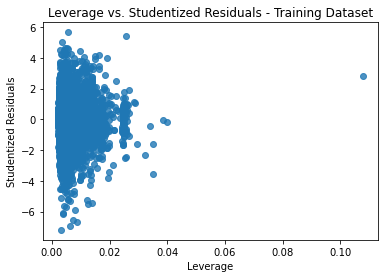

In [58]:
''' Identify and eliminate influential outliers '''

elim_infl_outliers("Training", X_train, y_train)

The number of influential observations in the Test dataset is 47.


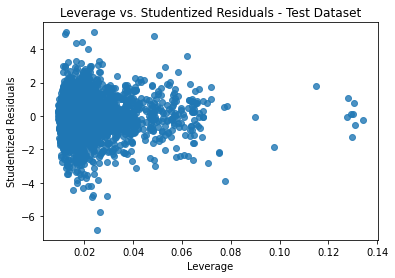

In [59]:
elim_infl_outliers("Test", X_test, y_test)

R-Squared of Predictions: 0.9065323871992232
Adjusted R-Squared of Predictions: 0.9045451398176492


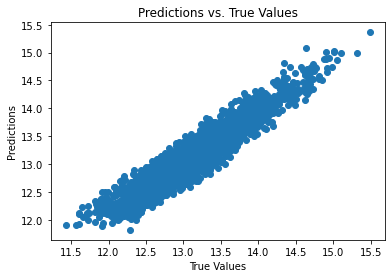

In [60]:
''' Assess Model Accuracy and Plot Predicted Values Against True Values In Test Set '''

lm = LinearRegression().fit(X_train, y_train)
y_hat = lm.predict(X_test)

r_squared = lm.score(X_test, y_test)
adj_r_squared = 1 - (1 - r_squared) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
print("R-Squared of Predictions: " + str(r_squared))
print("Adjusted R-Squared of Predictions: " + str(adj_r_squared))
plt.scatter(y_test, y_hat)
plt.title("Predictions vs. True Values")
plt.xlabel("True Values")
y_label = plt.ylabel("Predictions")

In [ ]:
''' To-Do '''
# 1. Add cross-validation to get the cross-predicted score
# 2. Look back at Duke homework code for additional ideas